*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 13: Parallelizing Neural Network Training with TensorFlow (Part 1/2)


Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow

Author: Sebastian Raschka & Vahid Mirjalili

Last updated: 2022-05-18

numpy     : 1.21.5
scipy     : 1.7.3
matplotlib: 3.5.1
tensorflow: 2.8.0



In [2]:
from IPython.display import Image
%matplotlib inline

## TensorFlow and training performance

### Performance challenges

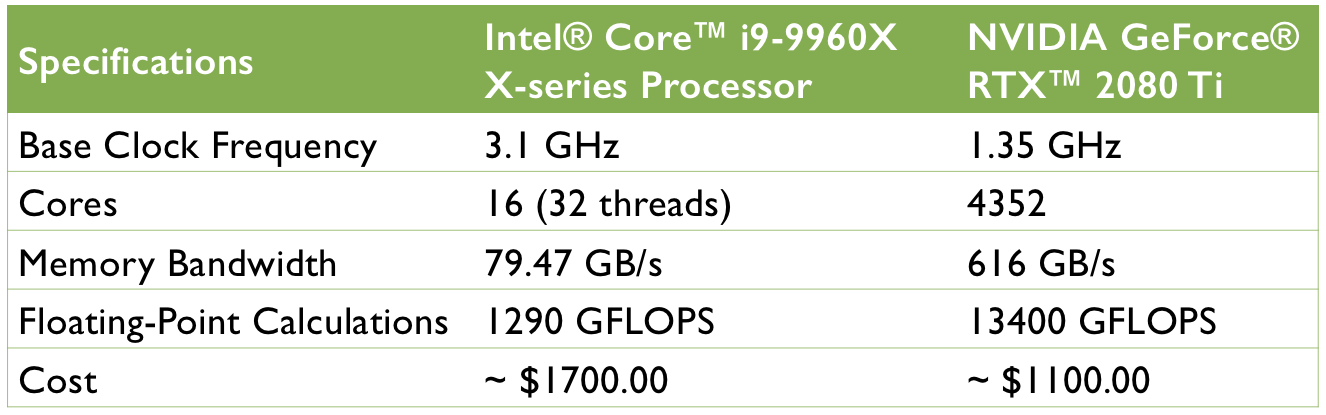

In [3]:
Image(filename='images/01.png', width=800)

### What is TensorFlow?

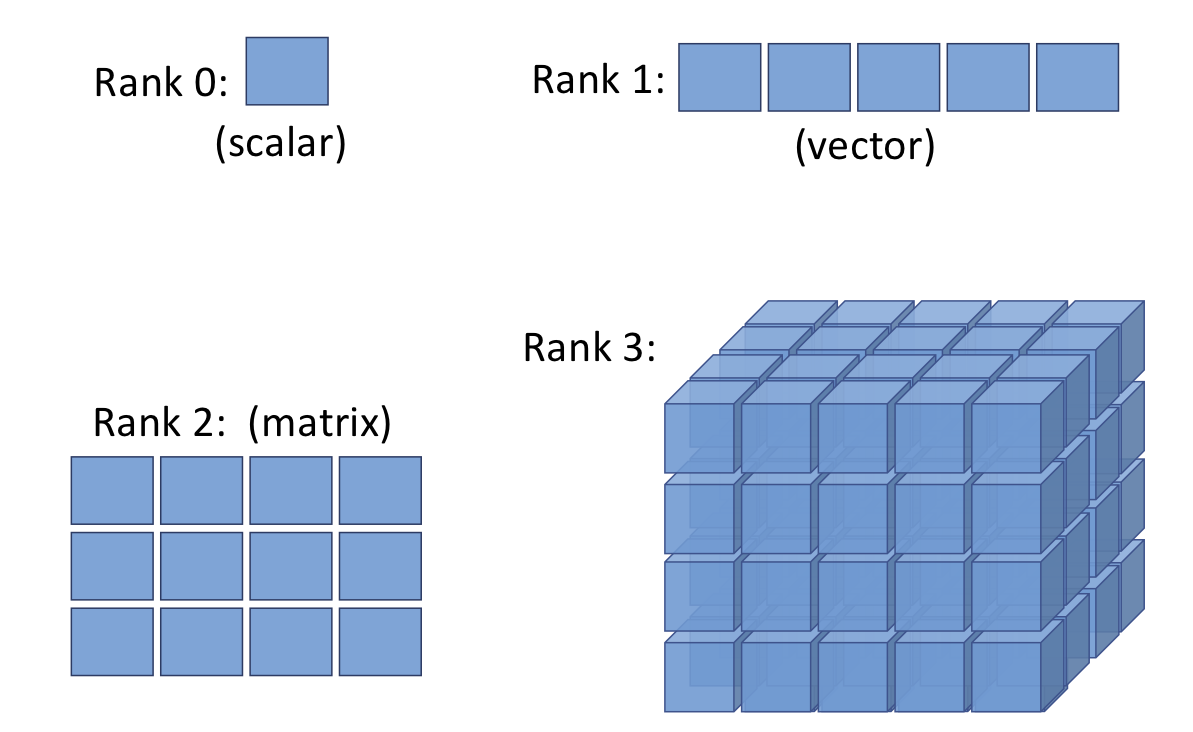

In [4]:
Image(filename='images/02.png', width=500)

### How we will learn TensorFlow

## First steps with TensorFlow

### Installing TensorFlow

In [1]:
#! pip install tensorflow

In [2]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
import numpy as np

np.set_printoptions(precision=3)

TensorFlow version: 2.8.0


In [3]:
! python -c 'import tensorflow as tf; print(tf.__version__)'

2.8.0


In [4]:
%env TF_CPP_MIN_LOG_LEVEL=3  # silence some TensorFlow warnings and logs

env: TF_CPP_MIN_LOG_LEVEL=3  # silence some TensorFlow warnings and logs


### Creating tensors in TensorFlow

In [5]:
a = np.array([1, 2, 3], dtype=np.int32)
b = [4, 5, 6]

t_a = tf.convert_to_tensor(a)
t_b = tf.convert_to_tensor(b)

print(t_a)
print(t_b)

Metal device set to: Apple M1 Pro
tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([4 5 6], shape=(3,), dtype=int32)


In [10]:
tf.is_tensor(a), tf.is_tensor(t_a)

(False, True)

In [11]:
t_ones = tf.ones((2, 3))

t_ones.shape

TensorShape([2, 3])

In [12]:
t_ones.numpy()

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [13]:
const_tensor = tf.constant([1.2, 5, np.pi], dtype=tf.float32)

print(const_tensor)

tf.Tensor([1.2   5.    3.142], shape=(3,), dtype=float32)


### Manipulating the data type and shape of a tensor

In [14]:
t_a_new = tf.cast(t_a, tf.int64)

print(t_a_new.dtype)

<dtype: 'int64'>


In [15]:
t = tf.random.uniform(shape=(3, 5))

t_tr = tf.transpose(t)
print(t.shape, ' --> ', t_tr.shape)

(3, 5)  -->  (5, 3)


In [18]:
t = tf.zeros((30,))

t_reshape = tf.reshape(t, shape=(5, 6))

print(t_reshape.shape)

(5, 6)


In [19]:
t = tf.zeros((1, 2, 1, 4, 1))

t_sqz = tf.squeeze(t, axis=(2, 4))

print(t.shape, ' --> ', t_sqz.shape)

(1, 2, 1, 4, 1)  -->  (1, 2, 4)


### Applying mathematical operations to tensors

In [20]:
tf.random.set_seed(1)

t1 = tf.random.uniform(shape=(5, 2), 
                       minval=-1.0,
                       maxval=1.0)

t2 = tf.random.normal(shape=(5, 2), 
                      mean=0.0,
                      stddev=1.0)


In [21]:
t3 = tf.multiply(t1, t2).numpy()
print(t3)

[[-0.22   0.072]
 [ 0.04   0.117]
 [-0.486 -0.208]
 [ 0.31   1.005]
 [ 0.206 -0.014]]


In [22]:
t4 = tf.math.reduce_mean(t1, axis=0)

print(t4)

tf.Tensor([-0.487 -0.236], shape=(2,), dtype=float32)


In [23]:
t5 = tf.linalg.matmul(t1, t2, transpose_b=True)

print(t5.numpy())

[[-0.148 -0.054 -0.356  0.486  0.682]
 [-0.353  0.158 -0.498  0.397  0.802]
 [-0.737  0.611 -0.693  0.081  0.863]
 [ 0.891 -1.27   0.186  1.315  0.487]
 [ 0.651 -0.871  0.206  0.809  0.192]]


In [24]:
t6 = tf.linalg.matmul(t1, t2, transpose_a=True)

print(t6.numpy())

[[-0.15   0.49 ]
 [ 1.836  0.973]]


In [25]:
norm_t1 = tf.norm(t1, ord=2, axis=1).numpy()

print(norm_t1)

[0.55  0.645 0.804 1.051 0.679]


In [26]:
np.sqrt(np.sum(np.square(t1), axis=1))

array([0.55 , 0.645, 0.804, 1.051, 0.679], dtype=float32)

### Split, stack, and concatenate tensors

In [27]:
tf.random.set_seed(1)

t = tf.random.uniform((6,))

print(t.numpy())

t_splits = tf.split(t, 3)

[item.numpy() for item in t_splits]

[0.227 0.467 0.18  0.544 0.159 0.712]


[array([0.227, 0.467], dtype=float32),
 array([0.18 , 0.544], dtype=float32),
 array([0.159, 0.712], dtype=float32)]

In [28]:
tf.random.set_seed(1)
t = tf.random.uniform((5,))

print(t.numpy())

t_splits = tf.split(t, num_or_size_splits=[3, 2])

[item.numpy() for item in t_splits]

[0.227 0.467 0.18  0.544 0.159]


[array([0.227, 0.467, 0.18 ], dtype=float32),
 array([0.544, 0.159], dtype=float32)]

In [29]:
A = tf.ones((3,))
B = tf.zeros((2,))

C = tf.concat([A, B], axis=0)
print(C.numpy())

[1. 1. 1. 0. 0.]


In [30]:
A = tf.ones((3,))
B = tf.zeros((3,))

S = tf.stack([A, B], axis=1)
print(S.numpy())

[[1. 0.]
 [1. 0.]
 [1. 0.]]


## Building input pipelines using tf.data: The TensorFlow Dataset API

### Creating a TensorFlow Dataset from existing tensors 

In [31]:
a = [1.2, 3.4, 7.5, 4.1, 5.0, 1.0]

ds = tf.data.Dataset.from_tensor_slices(a)

print(ds)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>


In [32]:
for item in ds:
    print(item)

tf.Tensor(1.2, shape=(), dtype=float32)
tf.Tensor(3.4, shape=(), dtype=float32)
tf.Tensor(7.5, shape=(), dtype=float32)
tf.Tensor(4.1, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [33]:
ds_batch = ds.batch(3)

for i, elem in enumerate(ds_batch, 1):
    print('batch {}:'.format(i), elem.numpy())

batch 1: [1.2 3.4 7.5]
batch 2: [4.1 5.  1. ]


### Combining two tensors into a joint dataset

In [34]:
tf.random.set_seed(1)

t_x = tf.random.uniform([4, 3], dtype=tf.float32)
t_y = tf.range(4)

In [35]:
ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)
    
ds_joint = tf.data.Dataset.zip((ds_x, ds_y))

for example in ds_joint:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.227 0.467 0.18 ]   y:  0
  x:  [0.544 0.159 0.712]   y:  1
  x:  [0.297 0.015 0.418]   y:  2
  x:  [0.17  0.567 0.805]   y:  3


In [36]:
## method 2:
ds_joint = tf.data.Dataset.from_tensor_slices((t_x, t_y))

for example in ds_joint:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.227 0.467 0.18 ]   y:  0
  x:  [0.544 0.159 0.712]   y:  1
  x:  [0.297 0.015 0.418]   y:  2
  x:  [0.17  0.567 0.805]   y:  3


In [37]:
ds_trans = ds_joint.map(lambda x, y: (x*2-1.0, y))

for example in ds_trans:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [-0.546 -0.066 -0.639]   y:  0
  x:  [ 0.088 -0.682  0.425]   y:  1
  x:  [-0.405 -0.969 -0.164]   y:  2
  x:  [-0.659  0.134  0.61 ]   y:  3


### Shuffle, batch, and repeat

In [38]:
tf.random.set_seed(1)
ds = ds_joint.shuffle(buffer_size=len(t_x))

for example in ds:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.297 0.015 0.418]   y:  2
  x:  [0.544 0.159 0.712]   y:  1
  x:  [0.227 0.467 0.18 ]   y:  0
  x:  [0.17  0.567 0.805]   y:  3


In [39]:
ds = ds_joint.batch(batch_size=3,
                    drop_remainder=False)

batch_x, batch_y = next(iter(ds))

print('Batch-x: \n', batch_x.numpy())

print('Batch-y:   ', batch_y.numpy())

Batch-x: 
 [[0.227 0.467 0.18 ]
 [0.544 0.159 0.712]
 [0.297 0.015 0.418]]
Batch-y:    [0 1 2]


In [40]:
ds = ds_joint.batch(3).repeat(count=2)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())


0 (3, 3) [0 1 2]
1 (1, 3) [3]
2 (3, 3) [0 1 2]
3 (1, 3) [3]


In [41]:
ds = ds_joint.repeat(count=2).batch(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())


0 (3, 3) [0 1 2]
1 (3, 3) [3 0 1]
2 (2, 3) [2 3]


In [42]:
tf.random.set_seed(1)

## Order 1: shuffle -> batch -> repeat
ds = ds_joint.shuffle(4).batch(2).repeat(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [2 1]
1 (2, 3) [0 3]
2 (2, 3) [0 3]
3 (2, 3) [1 2]
4 (2, 3) [3 0]
5 (2, 3) [1 2]


In [43]:
tf.random.set_seed(1)

## Order 1: shuffle -> batch -> repeat
ds = ds_joint.shuffle(4).batch(2).repeat(20)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [2 1]
1 (2, 3) [0 3]
2 (2, 3) [0 3]
3 (2, 3) [1 2]
4 (2, 3) [3 0]
5 (2, 3) [1 2]
6 (2, 3) [1 3]
7 (2, 3) [2 0]
8 (2, 3) [1 2]
9 (2, 3) [3 0]
10 (2, 3) [3 0]
11 (2, 3) [2 1]
12 (2, 3) [3 0]
13 (2, 3) [1 2]
14 (2, 3) [3 0]
15 (2, 3) [2 1]
16 (2, 3) [2 3]
17 (2, 3) [0 1]
18 (2, 3) [1 2]
19 (2, 3) [0 3]
20 (2, 3) [0 1]
21 (2, 3) [2 3]
22 (2, 3) [3 2]
23 (2, 3) [0 1]
24 (2, 3) [3 0]
25 (2, 3) [1 2]
26 (2, 3) [1 3]
27 (2, 3) [2 0]
28 (2, 3) [2 1]
29 (2, 3) [0 3]
30 (2, 3) [2 3]
31 (2, 3) [0 1]
32 (2, 3) [3 1]
33 (2, 3) [2 0]
34 (2, 3) [3 2]
35 (2, 3) [1 0]
36 (2, 3) [3 0]
37 (2, 3) [2 1]
38 (2, 3) [0 2]
39 (2, 3) [3 1]


In [44]:
tf.random.set_seed(1)

## Order 2: batch -> shuffle -> repeat
ds = ds_joint.batch(2).shuffle(4).repeat(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [0 1]
1 (2, 3) [2 3]
2 (2, 3) [0 1]
3 (2, 3) [2 3]
4 (2, 3) [2 3]
5 (2, 3) [0 1]


In [45]:
tf.random.set_seed(1)

## Order 2: batch -> shuffle -> repeat
ds = ds_joint.batch(2).shuffle(4).repeat(20)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [0 1]
1 (2, 3) [2 3]
2 (2, 3) [0 1]
3 (2, 3) [2 3]
4 (2, 3) [2 3]
5 (2, 3) [0 1]
6 (2, 3) [2 3]
7 (2, 3) [0 1]
8 (2, 3) [2 3]
9 (2, 3) [0 1]
10 (2, 3) [2 3]
11 (2, 3) [0 1]
12 (2, 3) [2 3]
13 (2, 3) [0 1]
14 (2, 3) [2 3]
15 (2, 3) [0 1]
16 (2, 3) [0 1]
17 (2, 3) [2 3]
18 (2, 3) [2 3]
19 (2, 3) [0 1]
20 (2, 3) [0 1]
21 (2, 3) [2 3]
22 (2, 3) [2 3]
23 (2, 3) [0 1]
24 (2, 3) [2 3]
25 (2, 3) [0 1]
26 (2, 3) [2 3]
27 (2, 3) [0 1]
28 (2, 3) [0 1]
29 (2, 3) [2 3]
30 (2, 3) [0 1]
31 (2, 3) [2 3]
32 (2, 3) [2 3]
33 (2, 3) [0 1]
34 (2, 3) [2 3]
35 (2, 3) [0 1]
36 (2, 3) [2 3]
37 (2, 3) [0 1]
38 (2, 3) [0 1]
39 (2, 3) [2 3]


### Creating a dataset from files on your local storage disk

In [46]:
import pathlib

imgdir_path = pathlib.Path('cat_dog_images')

file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])

print(file_list)

['cat_dog_images/cat-01.jpg', 'cat_dog_images/cat-02.jpg', 'cat_dog_images/cat-03.jpg', 'cat_dog_images/dog-01.jpg', 'cat_dog_images/dog-02.jpg', 'cat_dog_images/dog-03.jpg']


Image shape:  (900, 1200, 3)
Image shape:  (900, 1200, 3)
Image shape:  (900, 742, 3)
Image shape:  (800, 1200, 3)
Image shape:  (800, 1200, 3)
Image shape:  (900, 1200, 3)


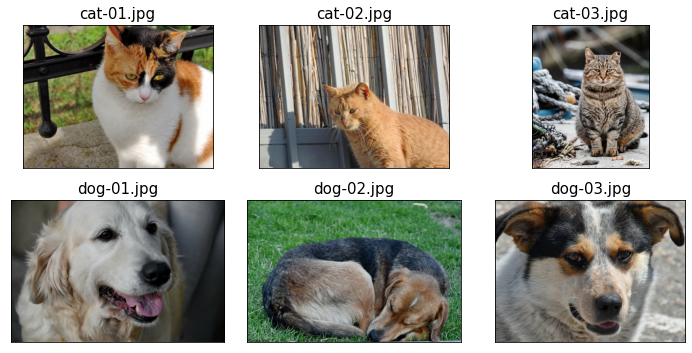

In [47]:
import matplotlib.pyplot as plt
import os


fig = plt.figure(figsize=(10, 5))
for i,file in enumerate(file_list):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    print('Image shape: ', img.shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
    
# plt.savefig('ch13-catdot-examples.pdf')
plt.tight_layout()
plt.show()

In [48]:
labels = [1 if 'dog' in os.path.basename(file) else 0
          for file in file_list]
print(labels)

[0, 0, 0, 1, 1, 1]


In [49]:
ds_files_labels = tf.data.Dataset.from_tensor_slices(
    (file_list, labels))

for item in ds_files_labels:
    print(item[0].numpy(), item[1].numpy())

b'cat_dog_images/cat-01.jpg' 0
b'cat_dog_images/cat-02.jpg' 0
b'cat_dog_images/cat-03.jpg' 0
b'cat_dog_images/dog-01.jpg' 1
b'cat_dog_images/dog-02.jpg' 1
b'cat_dog_images/dog-03.jpg' 1


(80, 120, 3) 0
(80, 120, 3) 0
(80, 120, 3) 0
(80, 120, 3) 1
(80, 120, 3) 1
(80, 120, 3) 1


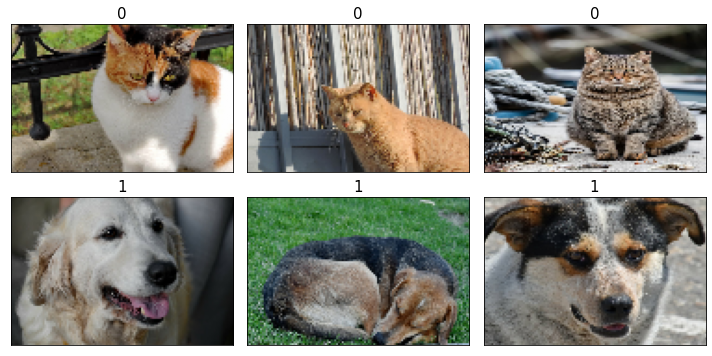

In [50]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image /= 255.0

    return image, label

img_width, img_height = 120, 80

ds_images_labels = ds_files_labels.map(load_and_preprocess)

fig = plt.figure(figsize=(10, 5))
for i,example in enumerate(ds_images_labels):
    print(example[0].shape, example[1].numpy())
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title('{}'.format(example[1].numpy()), 
                 size=15)
    
plt.tight_layout()
#plt.savefig('ch13-catdog-dataset.pdf')
plt.show()

### Fetching available datasets from the tensorflow_datasets library

In [51]:
#! pip install tensorflow-datasets

     |████████████████████████████████| 4.2 MB 78 kB/s eta 0:00:012
     |████████████████████████████████| 86 kB 7.7 MB/s eta 0:00:011
     |████████████████████████████████| 50 kB 5.8 MB/s  eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=7600a639dc22f22b51d2ad3d83f02dec77d750d5347aa5e018702ec94a0e456d
  Stored in directory: /Users/rerobbins/Library/Caches/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


In [52]:
import tensorflow_datasets as tfds

print(len(tfds.list_builders()))
print(tfds.list_builders()[:5])

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
## Run this to see the full list:
tfds.list_builders()

Fetching CelebA dataset

In [ ]:
celeba_bldr = tfds.builder('celeb_a')

print(celeba_bldr.info.features)
print('\n', 30*"=", '\n')
print(celeba_bldr.info.features.keys())
print('\n', 30*"=", '\n')
print(celeba_bldr.info.features['image'])
print('\n', 30*"=", '\n')
print(celeba_bldr.info.features['attributes'].keys())
print('\n', 30*"=", '\n')
print(celeba_bldr.info.citation)

In [ ]:
# Download the data, prepare it, and write it to disk
celeba_bldr.download_and_prepare()

In [ ]:
# Load data from disk as tf.data.Datasets
datasets = celeba_bldr.as_dataset(shuffle_files=False)

datasets.keys()

In [ ]:
#import tensorflow as tf
ds_train = datasets['train']
assert isinstance(ds_train, tf.data.Dataset)

example = next(iter(ds_train))
print(type(example))
print(example.keys())

In [ ]:
ds_train = ds_train.map(lambda item: 
     (item['image'], tf.cast(item['attributes']['Male'], tf.int32)))

In [ ]:
ds_train = ds_train.batch(18)
images, labels = next(iter(ds_train))

print(images.shape, labels)

In [ ]:
fig = plt.figure(figsize=(12, 8))
for i,(image,label) in enumerate(zip(images, labels)):
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image)
    ax.set_title('{}'.format(label), size=15)
    

plt.show()

Alternative ways for loading a dataset

In [ ]:
mnist, mnist_info = tfds.load('mnist', with_info=True,
                              shuffle_files=False)

print(mnist_info)

print(mnist.keys())

In [ ]:
ds_train = mnist['train']

assert isinstance(ds_train, tf.data.Dataset)

ds_train = ds_train.map(lambda item: 
     (item['image'], item['label']))

ds_train = ds_train.batch(10)
batch = next(iter(ds_train))
print(batch[0].shape, batch[1])

fig = plt.figure(figsize=(15, 6))
for i,(image,label) in enumerate(zip(batch[0], batch[1])):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image[:, :, 0], cmap='gray_r')
    ax.set_title('{}'.format(label), size=15)
    
plt.show()

<br>
<br>
<br>

---

Readers may ignore the next cell.

In [ ]:
! python ../.convert_notebook_to_script.py --input ch13_part1.ipynb --output ch13_part1.py